In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
plt.style.use("ggplot")


product/productId: asin, e.g. amazon.com/dp/B001E4KFG0
review/userId: id of the user, e.g. A3SGXH7AUHU8GW
review/profileName: name of the user
review/helpfulness: fraction of users who found the review helpful
review/score: rating of the product
review/time: time of the review (unix time)
review/summary: review summary
review/text: text of the review

In [9]:
import pandas as pd
from io import StringIO

# Initialize an empty list to store problematic row IDs
problematic_row_ids = []

# Read the CSV file line by line and handle exceptions
data = []
with open('Reviews.csv', 'r', encoding='utf-8') as file:
    for i, line in enumerate(file):
        try:
            # Attempt to parse the line as a CSV row
            pd.read_csv(StringIO(line), encoding='utf-8')
            data.append(line)
        except pd.errors.ParserError:
            # If an exception occurs, record the problematic row ID
            problematic_row_ids.append(i)

# Create a DataFrame from the valid rows
df = pd.read_csv(StringIO('\n'.join(data)), encoding='utf-8')

# Now, the DataFrame 'df' contains all the valid rows from the CSV file,
# and the list 'problematic_row_ids' contains the row IDs with parsing issues.


In [71]:
# downsizing the data for easy processing with my available GPU
output_excel_file = 'reviewswithout exception_output.xlsx'

# Save the DataFrame 'vaders' to an Excel file
df.to_excel(output_excel_file, index=False)
df= df.head(500)
df.shape
df['Score'].value_counts()

5    339
4     70
3     37
1     36
2     18
Name: Score, dtype: int64

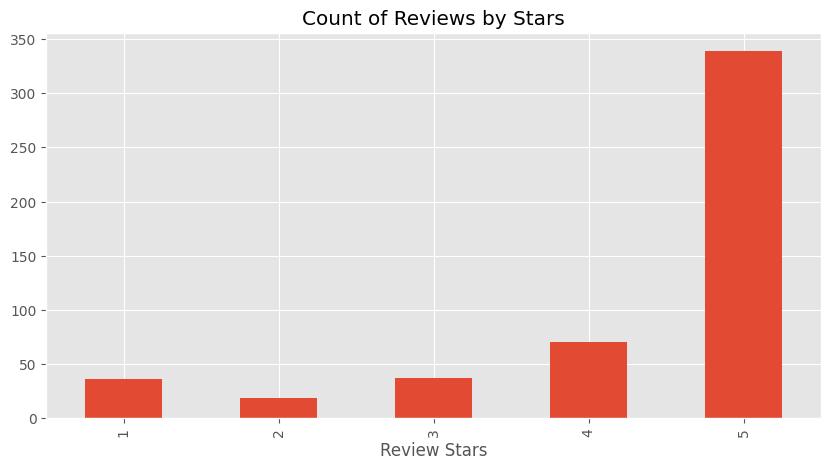

In [14]:
# QUICK EDA
ax=df['Score'].value_counts().sort_index()\
.plot(kind="bar",title='Count of Reviews by Stars',
      figsize=(10,5))
ax.set_xlabel('Review Stars')
plt.show()

we have biased reviews in our dataset

**BASIC Nltk**

In [16]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


lets see what nLtK can do out of the box

In [18]:
# nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [24]:

# To perform sentence tokenization using NLTK, you can use the sent_tokenize function from the nltk.tokenize module. Here's the code for sentence tokenization:

# Perform sentence tokenization
sentences = nltk.sent_tokenize(example)

# Print the result
sentences

['This oatmeal is not good.',
 "Its mushy, soft, I don't like it.",
 'Quaker Oats is the way to go.']

In [21]:
tokens = nltk.word_tokenize(example)
# tokens[:10]
tokens

['This',
 'oatmeal',
 'is',
 'not',
 'good',
 '.',
 'Its',
 'mushy',
 ',',
 'soft',
 ',',
 'I',
 'do',
 "n't",
 'like',
 'it',
 '.',
 'Quaker',
 'Oats',
 'is',
 'the',
 'way',
 'to',
 'go',
 '.']

In [25]:
# nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [26]:
# finiding parts of speech for these tockens
tagged = nltk.pos_tag(tokens)
tagged

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ'),
 (',', ','),
 ('I', 'PRP'),
 ('do', 'VBP'),
 ("n't", 'RB'),
 ('like', 'VB'),
 ('it', 'PRP'),
 ('.', '.'),
 ('Quaker', 'NNP'),
 ('Oats', 'NNPS'),
 ('is', 'VBZ'),
 ('the', 'DT'),
 ('way', 'NN'),
 ('to', 'TO'),
 ('go', 'VB'),
 ('.', '.')]

In [31]:
# nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [32]:
# Taking from here we can put entities
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


Step 1. VADER Seniment Scoring
We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

This uses a "bag of words" approach:
Stop words are removed
each word is scored and combined to a total score.

In [37]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

The tqdm library offers two primary functionalities:

Progress Bar Creation: You can wrap an iterable object (e.g., list, range, data generator) with tqdm to create a progress bar. As the loop iterates through the elements, tqdm updates and displays the progress bar.

Time Estimation: tqdm also provides an estimate of the time remaining based on the current progress. It calculates the average iteration time and uses it to estimate the time needed to complete the entire process.

In [35]:
# nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [46]:
# analysing Postive satment polarity score
sia.polarity_scores('I')
sia.polarity_scores('am')
sia.polarity_scores('so')
sia.polarity_scores('happy')
sia.polarity_scores('I am so happy !')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

here this statment has zero negative value after the sentiment analyser funct looked up against the polarity score of each of the word and calculated the polarity it came up with that the negative polarity score is zero,neutral is slightly higher but pos polarity score is 0.6 and compound which is the normalised score for the complete text aggreagation is 0.6 thus highlighting that the text has a positive score

In [47]:
# analysing negative satment polarity score
sia.polarity_scores('This is the worst thing ever.')


{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [48]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [49]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [50]:
res

{1: {'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'compound': 0.9441},
 2: {'neg': 0.138, 'neu': 0.862, 'pos': 0.0, 'compound': -0.5664},
 3: {'neg': 0.091, 'neu': 0.754, 'pos': 0.155, 'compound': 0.8265},
 4: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 5: {'neg': 0.0, 'neu': 0.552, 'pos': 0.448, 'compound': 0.9468},
 6: {'neg': 0.029, 'neu': 0.809, 'pos': 0.163, 'compound': 0.883},
 7: {'neg': 0.034, 'neu': 0.693, 'pos': 0.273, 'compound': 0.9346},
 8: {'neg': 0.0, 'neu': 0.52, 'pos': 0.48, 'compound': 0.9487},
 9: {'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'compound': 0.6369},
 10: {'neg': 0.0, 'neu': 0.705, 'pos': 0.295, 'compound': 0.8313},
 11: {'neg': 0.017, 'neu': 0.846, 'pos': 0.137, 'compound': 0.9746},
 12: {'neg': 0.113, 'neu': 0.887, 'pos': 0.0, 'compound': -0.7579},
 13: {'neg': 0.031, 'neu': 0.923, 'pos': 0.046, 'compound': 0.296},
 14: {'neg': 0.0, 'neu': 0.355, 'pos': 0.645, 'compound': 0.9466},
 15: {'neg': 0.104, 'neu': 0.632, 'pos': 0.264, 'compound': 0.6486},
 

In [57]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')
vaders.head()
# Specify the file path where you want to save the Excel file
output_excel_file = 'vaders_output.xlsx'

# Save the DataFrame 'vaders' to an Excel file
vaders.to_excel(output_excel_file, index=False)

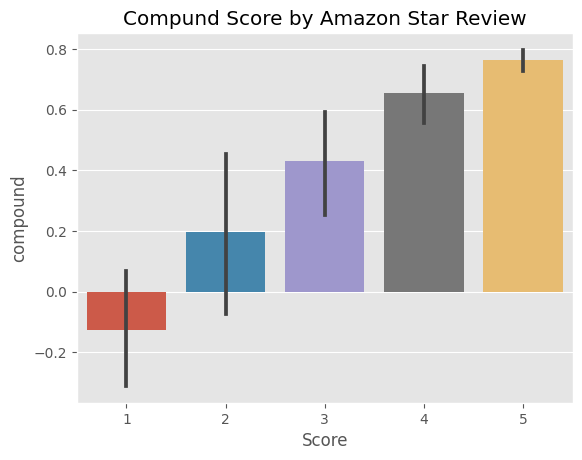

In [55]:
# Plot VADER results
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

here we can see as per the dataset it is showing the scores wrt the compound scores which reflects as our dataset

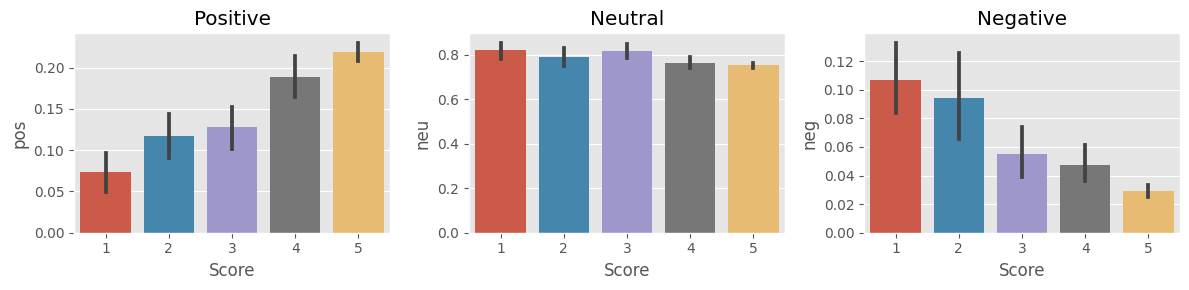

In [56]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

NOTE : POS,NEG AND NEU WILL RANGE BETWENEEN 0 TO 1 AND THE O MEANS LEAST NEG OR NEU OR POSITIVE AND 1 MEANS HIGHLY NEG ,NEU ,POSTHERE WE CAN SEE POSITIVITY IS HIGHER AS THE SCORE IS HIGHER
VADER IS VALUABLE WHICH SHOWS THAT THE AFTER WE HAVE GROUPED THE DATASET WRT SCORES AND PLOTTED THE AVERAGE OF THE POS IN THE 1st chart we can see that 5 has the maximum avearge values wrt polarity score, similarly for Neutral we chaeked that for each score the average polarity score is same. and for the last graph we can see that the polarityscore for the 1 score is highest thus specifying that the 1 score corresponds to negative statments and 5 means a positive score.thus VADER IS VALUABLE IN HAVING THIS CONNECTION BETWEEN THE SENTIMENT SCORE OF TEXT AND THE SCORE FEATURE OF THE DATASET

Step 3. Roberta Pretrained Model
Use a model trained of a large corpus of data.
Transformer model accounts for the words but also the context related to other words.

eaRLIER WE USED ONE WORD BUT IT MISSED THE SARCASM AND CONTEXTUAL RELATIONSHIPS SO HERE WE ARE CHECKING THE SIGNIFICANCE OF DEEPLEARNING tRANSFORMERS TO CHECK ITS IMPORTANCE AND EVALUATE

The "cardiffnlp/twitter-roberta-base-sentiment" model is a variant of the RoBERTa model fine-tuned specifically for sentiment analysis on Twitter data. RoBERTa is a highly effective language representation model based on the transformer architecture. The "twitter-roberta-base-sentiment" variant is fine-tuned to classify text into sentiment categories, such as positive, negative, or neutral, typically using three output nodes.

In [59]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.4 MB/s eta 0:00:00


In [60]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [61]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [62]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [65]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)
scores

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687476, 'roberta_pos': 0.002957372}


array([0.97635514, 0.02068748, 0.00295737], dtype=float32)

<h2>Conclusion:</h2>
<p>
    <b>From the Sentiment Analysis Outputs:</b>
    <ul>
        <li>VADER Sentiment Analysis Output:</li>
        <blockquote>
            <p>{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}</p>
        </blockquote>
        <p>VADER's sentiment analysis output provides sentiment scores for the input text. The scores indicate the proportion of negative, neutral, and positive sentiments in the text, as well as an overall compound score.</p>
        <ul>
            <li>'neg': 0.22 means approximately 22% of the text has negative sentiment.</li>
            <li>'neu': 0.78 means approximately 78% of the text has neutral sentiment.</li>
            <li>'pos': 0.0 means there are no words with positive sentiment in the text.</li>
            <li>'compound': -0.5448 is an overall sentiment score, combining both positive and negative sentiments. The negative compound score indicates a negative overall sentiment.</li>
        </ul>
        <li>RoBERTa Sentiment Analysis Output:</li>
        <blockquote>
            <p>{'roberta_neg': 0.97635514, 'roberta_neu': 0.02068748, 'roberta_pos': 0.00295737}</p>
        </blockquote>
        <p>The RoBERTa model's sentiment analysis output provides sentiment probabilities for the input text. The probabilities indicate the model's confidence that the text belongs to each sentiment class.</p>
        <ul>
            <li>'roberta_neg': 0.97635514 means the model predicts with high confidence (approximately 97.6%) that the text has negative sentiment.</li>
            <li>'roberta_neu': 0.02068748 means the model predicts with very low confidence (approximately 2.1%) that the text has neutral sentiment.</li>
            <li>'roberta_pos': 0.00295737 means the model predicts with very low confidence (approximately 0.3%) that the text has positive sentiment.</li>
        </ul>
    </ul>
</p>
<p>
    <b>Conclusions:</b>
    <ul>
        <li>Both VADER and the RoBERTa model agree that the input text has a negative sentiment, as indicated by their respective sentiment scores and probabilities. This aligns with the statement "This oatmeal is not good."</li>
        <li>VADER assigns approximately 22% negative sentiment and 78% neutral sentiment, while RoBERTa predicts almost all of the text (97.6%) to be negative sentiment.</li>
        <li>RoBERTa's low probabilities for neutral and positive sentiment suggest that it is highly confident in its negative sentiment prediction.</li>
    </ul>
</p>


In [67]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [68]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [69]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

Compare Scores between

In [70]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

combine and compare

In [73]:
# sns.pairplot(data=results_df,
#              vars=['vader_neg', 'vader_neu', 'vader_pos',
#                   'roberta_neg', 'roberta_neu', 'roberta_pos'],
#             hue='Score',
#             palette='tab10')
# plt.show()

Step 4: Review Examples:
Positive 1-Star and Negative 5-Star Reviews
Lets look at some examples where the model scoring and review score differ the most.

In [76]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

As we can see thought this statment has a highest pos score but this is a sarcastic statment AND A NEGATIVE REVIEW stating tht the customer is not at all happy with the product.so roberta model failed on this review

In [77]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

here with the vader model as well we see that their is a failure in sentiment analysis .This statment specifies that the customer was angry abt the service and used sarcasm to state that  since it was cancelled without a problem but vader classified it as a positive

# negative sentiment 5-Star view

In [78]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [79]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

The Transformers Pipeline;
*    Quick & easy way to run sentiment predictions






In [80]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [89]:
sent_pipeline('I love sentiment analysis! its cool , really a brain racker ,so many things to take into account why does it not take the relation ship. u must be kidding')

[{'label': 'POSITIVE', 'score': 0.994724690914154}]

i just removed the , after cool and added but and the same statment changed from positive with a 0.99 score to negative 0.98

In [91]:
sent_pipeline('I love sentiment analysis! its cool but really a brain racker ,so many things to take into account why does it not take the relation ship. u must be kidding')

[{'label': 'NEGATIVE', 'score': 0.985082745552063}]

In [83]:
# check on previous example
sent_pipeline(example)

[{'label': 'NEGATIVE', 'score': 0.9994776844978333}]